<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [10]:
from google.colab import files
files.upload()

Saving kaggle 18.32.13.json to kaggle 18.32.13 (1).json


{'kaggle 18.32.13 (1).json': b'{"username":"anigasitashvili","key":"373c2b9f2c34a9b29562a5a4a9b08fcf"}'}

In [11]:
!mv "kaggle 18.32.13.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!ls -l ~/.kaggle/

total 4
-rw------- 1 root root 71 Jul  1 14:40 kaggle.json


In [15]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 690MB/s]


In [16]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [17]:
!unzip '*.csv.zip'

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  features.csv.zip
  inflating: features.csv            

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.


In [18]:
!unzip '*.csv.zip'

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

4 archives were successfully processed.


In [19]:
import pandas as pd

# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# Explore the data
print("Train shape:", train.shape)
print(train.head())
print(train.columns)

print("\nTest shape:", test.shape)
print(test.head())
print(test.columns)

print("\nFeatures shape:", features.shape)
print(features.head())
print(features.columns)

print("\nStores shape:", stores.shape)
print(stores.head())
print(stores.columns)

print("\nSample Submission shape:", sample_submission.shape)
print(sample_submission.head())
print(sample_submission.columns)

Train shape: (421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

Test shape: (115064, 4)
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

Features shape: (8190, 12)
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        3

In [21]:
# Merge train and test with features and stores
train_merged = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
train_merged = pd.merge(train_merged, stores, on='Store', how='left')

test_merged = pd.merge(test, features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_merged = pd.merge(test_merged, stores, on='Store', how='left')

# Convert Date to datetime
train_merged['Date'] = pd.to_datetime(train_merged['Date'])


In [22]:
# Sort by date
train_merged = train_merged.sort_values('Date')

# Calculate split indices
n = len(train_merged)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split
train_data = train_merged.iloc[:train_end]
val_data = train_merged.iloc[train_end:val_end]
test_data = train_merged.iloc[val_end:]

print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Test (local):", test_data.shape)

Train: (252942, 16)
Validation: (84314, 16)
Test (local): (84314, 16)


<class 'pandas.core.frame.DataFrame'>
Index: 252942 entries, 0 to 27632
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         252942 non-null  int64         
 1   Dept          252942 non-null  int64         
 2   Date          252942 non-null  datetime64[ns]
 3   Weekly_Sales  252942 non-null  float64       
 4   IsHoliday     252942 non-null  bool          
 5   Temperature   252942 non-null  float64       
 6   Fuel_Price    252942 non-null  float64       
 7   MarkDown1     0 non-null       float64       
 8   MarkDown2     0 non-null       float64       
 9   MarkDown3     0 non-null       float64       
 10  MarkDown4     0 non-null       float64       
 11  MarkDown5     0 non-null       float64       
 12  CPI           252942 non-null  float64       
 13  Unemployment  252942 non-null  float64       
 14  Type          252942 non-null  object        
 15  Size          252942 no

<Axes: >

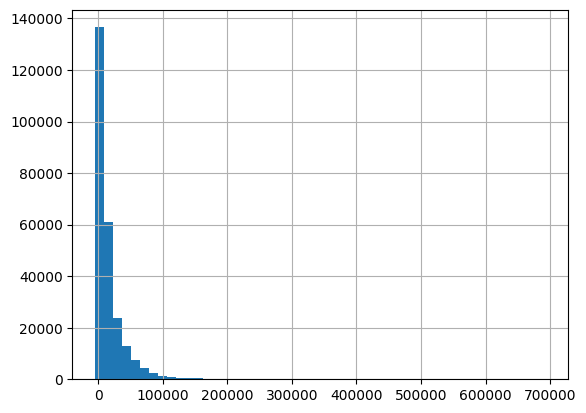

In [23]:
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())
train_data['Weekly_Sales'].hist(bins=50)

In [33]:
def preprocess(df):
    # Encode categorical
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df = df.copy()  # Avoid SettingWithCopyWarning
    df['Type'] = df['Type'].map(type_map)
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    # Date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    # Fill MarkDown NaNs
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    # Drop Date column
    df = df.drop(columns=['Date'])
    return df

In [34]:
df.loc[:, 'Type'] = df['Type'].map(type_map)
df.loc[:, 'IsHoliday'] = df['IsHoliday'].astype(int)
df.loc[:, 'Year'] = df['Date'].dt.year

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

preprocess_transformer = FunctionTransformer(preprocess)

# Build the pipeline
pipeline = Pipeline([
    ('preprocess', preprocess_transformer),
    ('model', lgb.LGBMRegressor(random_state=42, n_estimators=1000))
])

# Fit the pipeline
pipeline.fit(train_data, train_data['Weekly_Sales'])

# Predict
y_pred = pipeline.predict(val_data)

# Evaluate
rmse = np.sqrt(mean_squared_error(val_data['Weekly_Sales'], y_pred))
print("Validation RMSE:", rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1493
[LightGBM] [Info] Number of data points in the train set: 252942, number of used features: 13
[LightGBM] [Info] Start training from score 15896.074660
Validation RMSE: 2336.602892309834


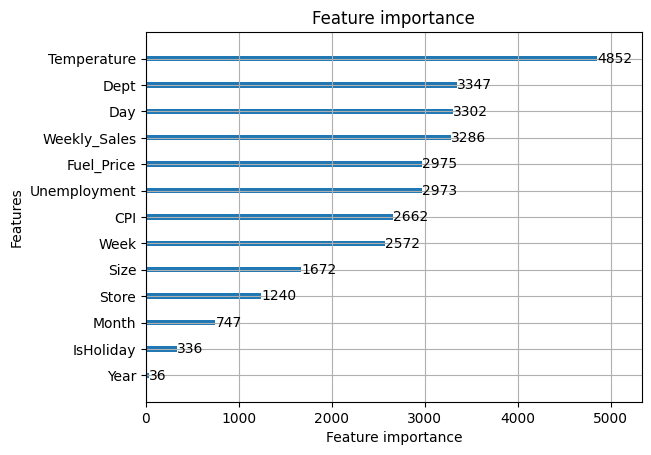

In [40]:
import matplotlib.pyplot as plt
lgb.plot_importance(pipeline.named_steps['model'], max_num_features=15)
plt.show()

In [41]:
print(train_data.shape)
print(val_data.shape)

(252942, 20)
(84314, 20)


In [42]:
feature_names = pipeline.named_steps['model'].feature_name_
print("Number of features used by LightGBM:", len(feature_names))
print("Feature names:", feature_names)

Number of features used by LightGBM: 19
Feature names: ['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week', 'Day']
